In [1]:
import random
import torch
import numpy as np
import time

from itertools import count
from train_mdqn import DQN
from env import ElastisityEnv
from pod_controller import get_loadbalancer_external_port
from utils import make_request

from spam_cluster import spam_requests_single

loadbalancer_port = get_loadbalancer_external_port(service_name='ingress-nginx-controller')

# def calculate_latency(num_requests):
#     url = f"http://localhost:{loadbalancer_port}/predict"
#     latencies = []
#     for _ in range(num_requests):
#         data = {
#             "feature": random.randint(0, 130)
#         }
#         latency = make_request(url, data)
#         if latency:
#             latencies.append(latency)
#     a = np.array(latencies)
#     # return a.prod()**(1.0/len(a))
#     return a.mean() if len(a) > 0 else 0

In [9]:
calculate_latency(5)

0.019176244735717773

In [28]:
mdqn_latencies = []
mdqn_mean_percentages = []
def infer_mdqn(n_agents=3, model='mdqn300ep500m', time_limit=60):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_agents = 3
    envs = [ElastisityEnv(i) for i in range(1, n_agents + 1)]

    state = envs[0].reset()
    n_actions = envs[0].action_space.n
    n_observations = len(state) * len(state[0])

    agents = [DQN(n_observations, n_actions).to(device) for _ in range(n_agents)]
    url_spam = f"http://localhost:{get_loadbalancer_external_port(service_name='ingress-nginx-controller')}/predict"
    USERS = 5

    for i, agent in enumerate(agents):
        agent.load_state_dict(torch.load(f'../trained/{model}/model_weights_agent_{i}.pth'))
        print(f'Loaded weights for agent {i}')
        agent.eval()

    for env in envs:
        env.MAX_CPU_LIMIT = 1000
    INITIAL_RESOURCES = 1000
    max_group = INITIAL_RESOURCES
    for env in envs:
        max_group -= env.ALLOCATED
    for env in envs:
        env.AVAILABLE = max_group

    start_time = time.time()

    states = [env.reset() for env in envs]
    states = [torch.tensor(np.array(state).flatten(), dtype=torch.float32, device=device).unsqueeze(0) for state in states]
    while time.time() - start_time < time_limit:
        time.sleep(1)
        latencies = spam_requests_single(USERS, url_spam)

        with torch.no_grad():
            actions = [dqn(state).max(1).indices.view(1, 1) for dqn, state in zip(agents, states)]

        cpu_percentages = []
        next_states, rewards, dones = [], [], []
        for i, action in enumerate(actions):
            observation, reward, done, _ = envs[i].step(action.item())
            next_states.append(np.array(observation).flatten())
            rewards.append(reward)
            dones.append(done)
            cpu_percentages.append(envs[i].last_cpu_percentage)
            # if done:
            #     next_states[i] = None

        max_group = INITIAL_RESOURCES
        for env in envs:
            max_group -= env.ALLOCATED
        for env in envs:
            env.AVAILABLE = max_group  

        states = [torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) if observation is not None else None for observation in next_states]
        mdqn_mean_percentages.append(np.mean(cpu_percentages))
        latencies = [latency for latency in latencies if latency is not None]
        mdqn_latencies.append(np.mean(latencies))


In [29]:
import time
import random

from pod_controller import create_pod_from, patch_pod, delete_pod, set_initial_values
from utils import init_nodes, load_config

t_mean_percentages = []
t_latencies = []
def infer_thresholding(time_limit=60):
    DEBUG = True
    custom_app_label = "app=localization-api"
    scale_cpu = 50
    max_cpu = 1000
    min_cpu = 50
    UPPER = 60
    LOWER = 30
    action_interval = 1

    AVAILABLE = 1000

    nodes = init_nodes(DEBUG, custom_label=custom_app_label)
    
    url_spam = f"http://localhost:{get_loadbalancer_external_port(service_name='ingress-nginx-controller')}/predict"
    USERS = 5

    updated_container_ids = []
    start_time = time.time()
    while time.time() - start_time < time_limit:
        start_time_loop = time.time()
        cpu_percentages = []
        AVAILABLE = 1000

        for node in nodes:
            for container_id, (pod_name, container_name, pod_ip) in list(node.get_containers().items()):
                (cpu_limit, cpu, cpu_p), (_, _, _), (_, _) = node.get_container_usage(container_id)
                AVAILABLE -= cpu_limit

        latencies = spam_requests_single(USERS, url_spam)
        for node in nodes:
            for container_id, (pod_name, container_name, pod_ip) in list(node.get_containers().items()):
                (cpu_limit, cpu, cpu_p), (_, _, _), (_, _) = node.get_container_usage(container_id)
                
                cpu_percentages.append(cpu_p)
                if cpu_p > UPPER and AVAILABLE >= scale_cpu:
                    cpu_limit = min(max_cpu, int(cpu_limit) + scale_cpu)
                    patch_pod(pod_name, cpu_request=f"{cpu_limit}m", cpu_limit=f"{cpu_limit}m",
                                container_name=container_name, debug=DEBUG)
                    AVAILABLE -= scale_cpu
                    if container_id not in updated_container_ids:
                        updated_container_ids.append(container_id)
                elif container_id in updated_container_ids and cpu_p < LOWER:
                    cpu_limit = max(min_cpu, int(cpu_limit) - scale_cpu)
                    patch_pod(pod_name, cpu_request=f"{cpu_limit}m", cpu_limit=f"{cpu_limit}m",
                                container_name=container_name, debug=DEBUG)
                    AVAILABLE += scale_cpu
                    if cpu_limit == min_cpu:
                        updated_container_ids.remove(container_id)
        
        elapsed_time = time.time() - start_time_loop
        t_mean_percentages.append(np.mean(cpu_percentages))
        latencies = [latency for latency in latencies if latency is not None]
        t_latencies.append(np.mean(latencies))
        if elapsed_time < action_interval:
            time.sleep(action_interval - elapsed_time)

In [34]:
import subprocess
import matplotlib.pyplot as plt

mdqn_latencies = []
mdqn_mean_percentages = []

t_latencies = []
t_mean_percentages = []

monitor_time = 2 * 60

spam_process = subprocess.Popen(['python', 'spam_cluster.py', '--users', '45', '--interval', '500'])
set_initial_values()
infer_mdqn(3, 'mdqn600ep500m', monitor_time * 2)
spam_process.terminate()

spam_process = subprocess.Popen(['python', 'spam_cluster.py', '--users', '45', '--interval', '500'])
set_initial_values()
infer_thresholding(monitor_time)
spam_process.terminate()


Pod localization-api1 patched successfully to 50m request and 50m limit
Pod localization-api2 patched successfully to 50m request and 50m limit
Pod localization-api3 patched successfully to 50m request and 50m limit
Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi1:193.2.205.192, ca: 10.1.245.1, pods: [('localization-api1', 'localization-api', '10.1.245.8'), ('localization-api3', 'localization-api', '10.1.245.9')]
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.10')]

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi1:193.2.205.192, ca: 10.1.245.1, pods: [('localization-api1', 'localization-api', '10.1.245.8'), ('localization-api3', 'localization-api', '10.1.245.9')]
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.10')]

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspbe

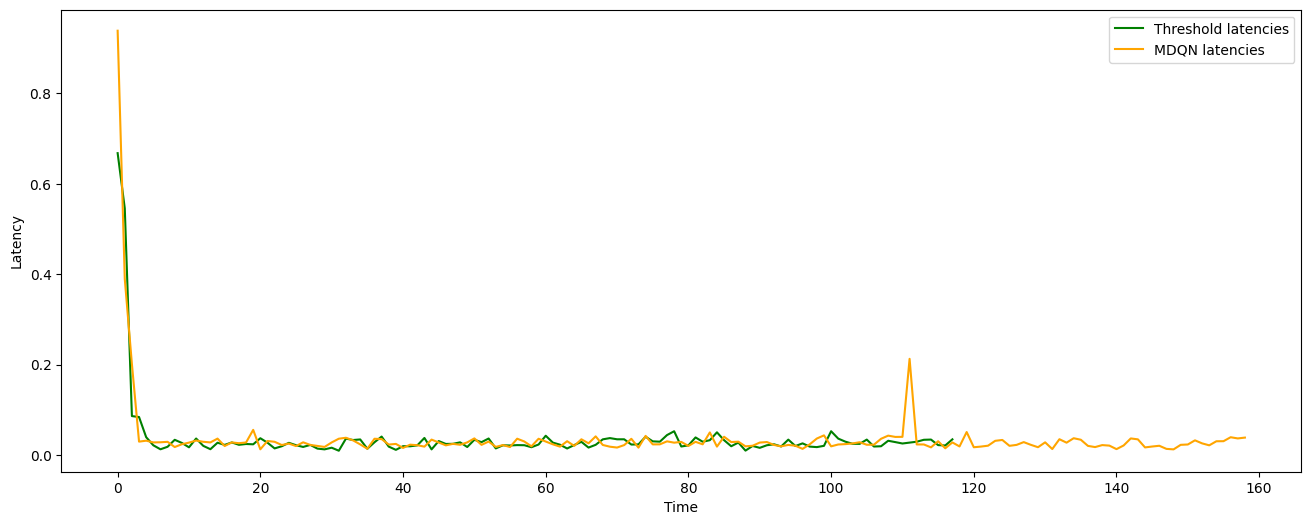

In [35]:
plt.figure(figsize=(16, 6))
plt.plot(t_latencies, color='green', label='Threshold latencies')
plt.plot(mdqn_latencies, color='orange', label='MDQN latencies')
plt.xlabel('Time')
plt.ylabel('Latency')
plt.legend()
plt.show()


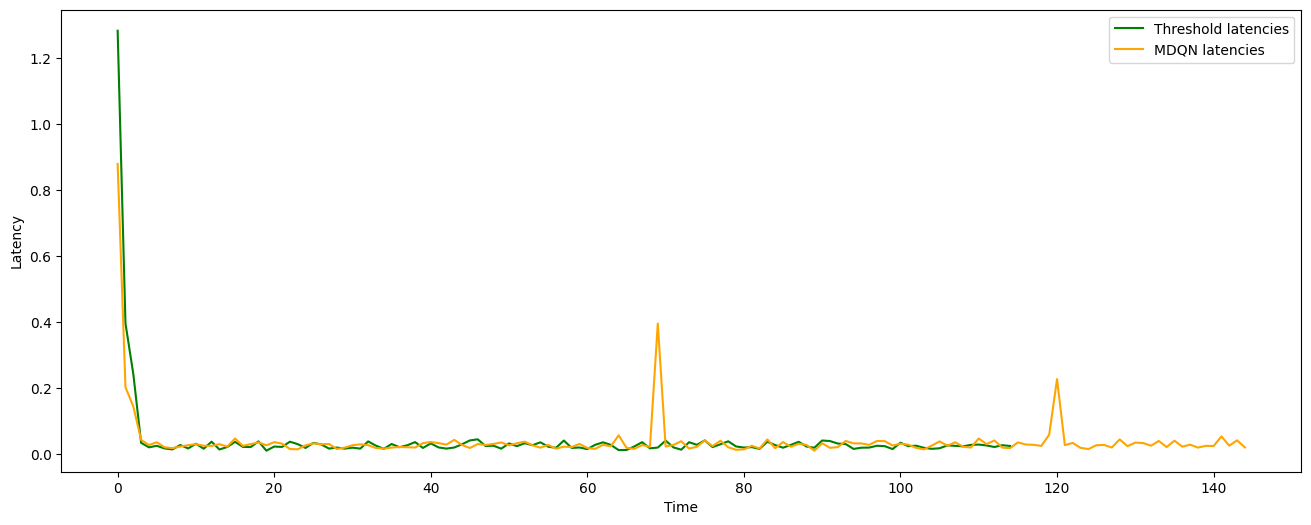

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(t_latencies, color='green', label='Threshold latencies')
plt.plot(mdqn_latencies, color='orange', label='MDQN latencies')
plt.xlabel('Time')
plt.ylabel('Latency')
plt.legend()
plt.show()


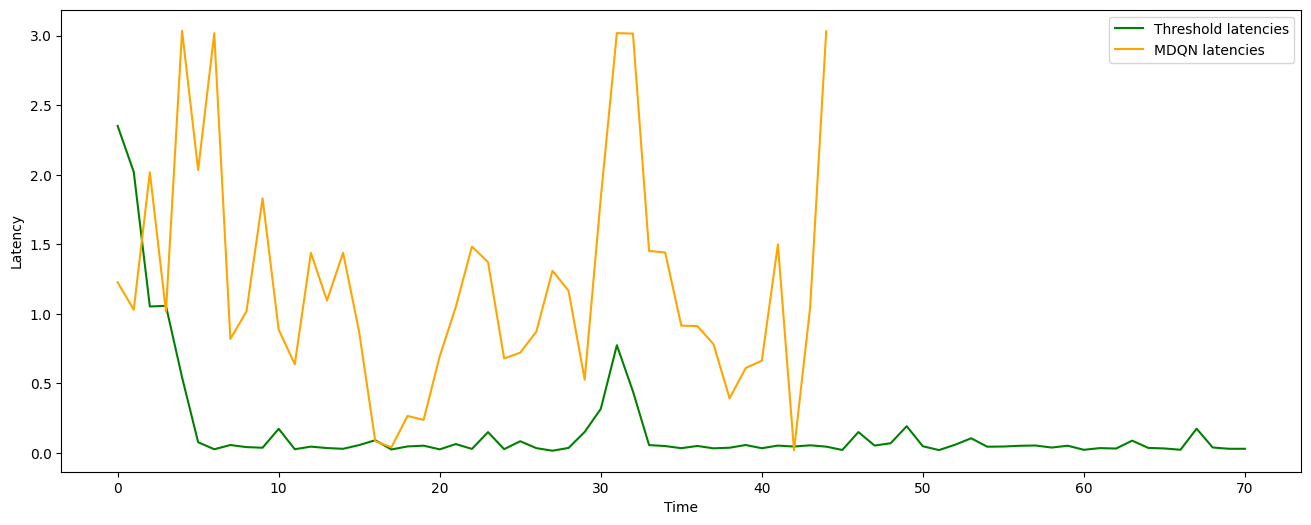

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(t_latencies[5:], color='green', label='Threshold latencies')
plt.plot(mdqn_latencies[5:], color='orange', label='MDQN latencies')
plt.xlabel('Time')
plt.ylabel('Latency')
plt.legend()
plt.show()


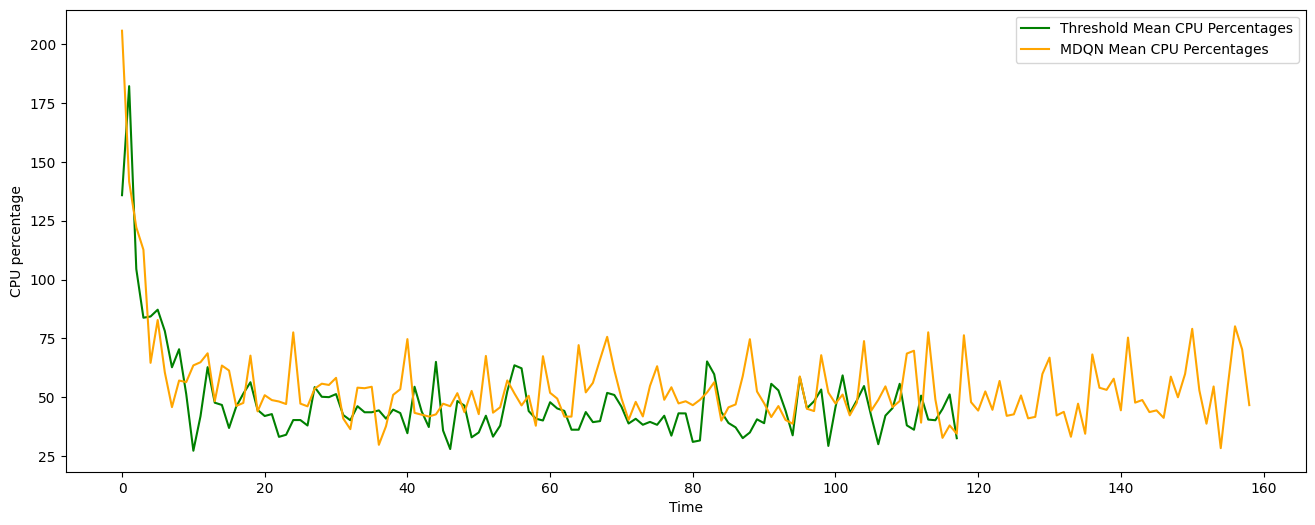

In [36]:
plt.figure(figsize=(16, 6))
plt.plot(t_mean_percentages, color='green', label='Threshold Mean CPU Percentages')
plt.plot(mdqn_mean_percentages, color='orange', label='MDQN Mean CPU Percentages')
plt.xlabel('Time')
plt.ylabel('CPU percentage')
plt.legend()
plt.show()

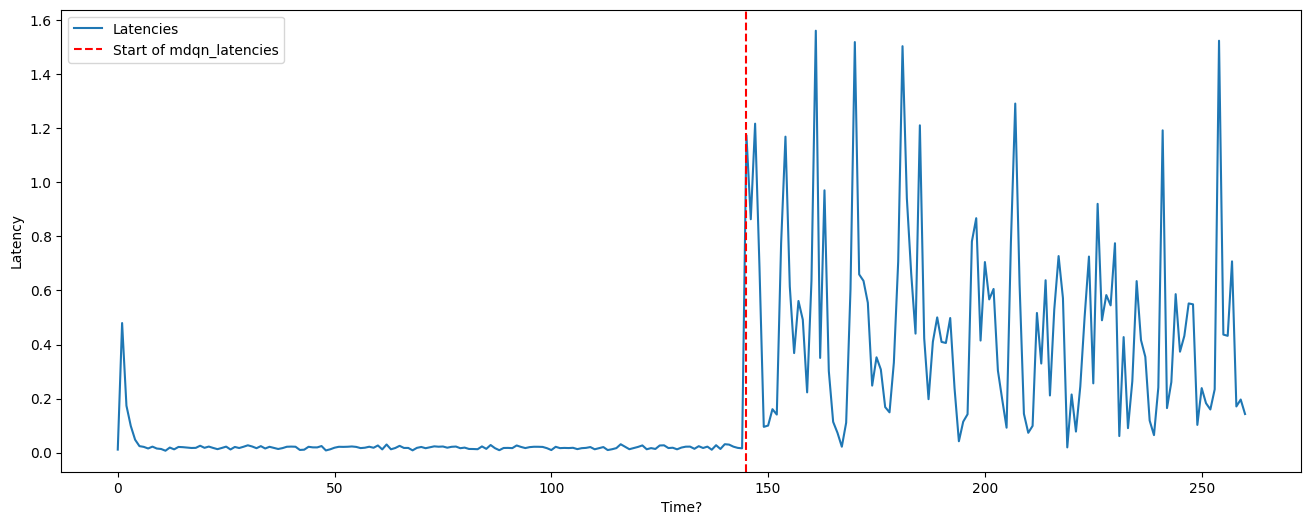

In [15]:
latencies = np.concatenate((t_latencies, mdqn_latencies))
plt.figure(figsize=(16, 6))
plt.plot(latencies)
plt.axvline(x=len(t_latencies), color='r', linestyle='--')
plt.xlabel('Time?')
plt.ylabel('Latency')
plt.legend(['Latencies', 'Start of mdqn_latencies'])
plt.show()
